<a href="https://colab.research.google.com/github/atharvakale31/PR_ML/blob/master/Programming_Probastically.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
np.random.seed(123)

In [2]:
az.style.use('arviz-darkgrid')

Generating Synthetic data.

In [3]:
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])


1.   For the likelihood, we will use the binomial distribution with n=1
and p = $\theta$
2.   for the prior, a beta distribution with the parameters $\alpha$=$\beta$=1



In [4]:
with pm.Model() as our_first_model:
  
    # a priori 
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [5]:
print(trace[1])
print(trace[0])

{'θ_logodds__': -1.5270497071885072, 'θ': 0.17842575899392316}
{'θ_logodds__': -1.1251701698367444, 'θ': 0.24505352995582733}


# Summarizing the posterior


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e92106510>,
      dtype=object)

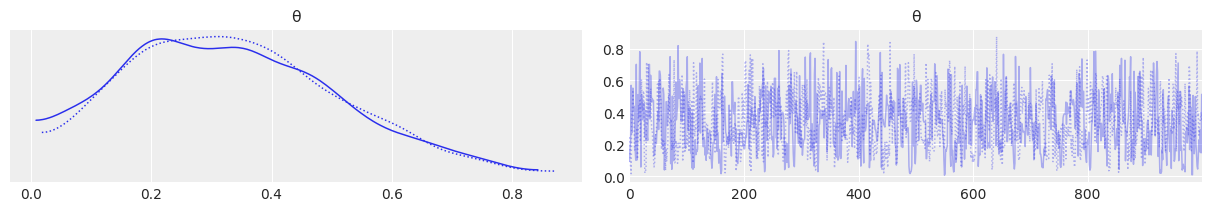

In [6]:
az.plot_trace(trace)

In [7]:
az.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.336,0.172,0.026,0.637,0.006,0.004,731.0,975.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


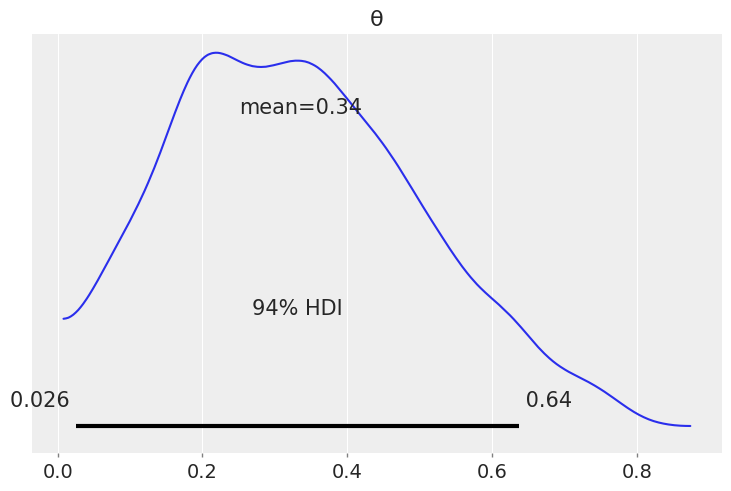

In [8]:
az.plot_posterior(trace)

## Region Of Practical Equivalence (ROPE):
In practice, we can relax the definition of fairness and we can say that a fair coin is one with a value of around 0.5.   
For example, we could say that any value in the interval [0.45, 0.55] will be, for our purposes, practically equivalent to 0.5. We call this interval a Region Of Practical Equivalence.   
* The ROPE does not overlap with the HPD; we can say the coin is not fair.
* ROPE contains the entire HPD; we can say the coin is fair .
* The ROPE partially overlaps with HPD; we cannot say the coin is fair or unfair.

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


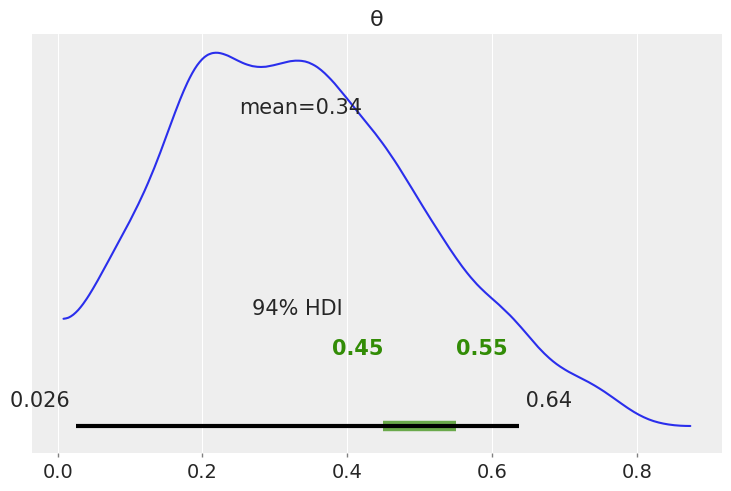

In [9]:
az.plot_posterior(trace, rope=[0.45, .55])

Another tool we can use to help us make a decision is to compare the posterior against a reference value

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


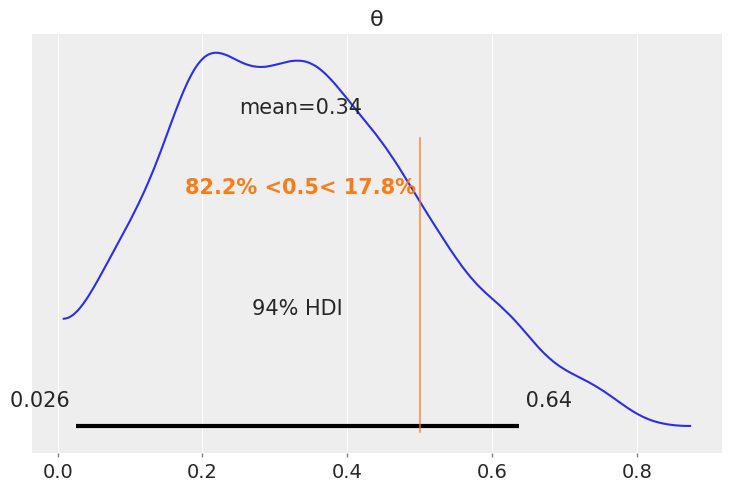

In [10]:
az.plot_posterior(trace, ref_val=0.5)

# Loss Functions
The key idea is to use a function that captures how different the true value and the estimated value of a parameter are.
Eg Loss Fucntions:
* Quadratic Loss
* Absolute Loss 


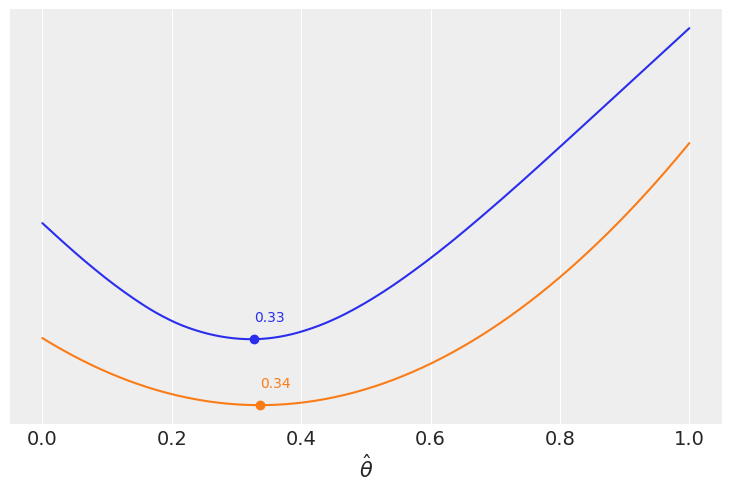

In [11]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid] #absolute loss
lossf_b = [np.mean((i - θ_pos)**2) for i in grid] #quadratic loss

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')


What is interesting from this result is that the first value is equal to the median of the posterior and the last value is equal to the mean of the posterior.  
Different loss functions are related to different point-estimates

In [12]:
np.mean(θ_pos), np.median(θ_pos)

(0.3359887424524105, 0.32390894266092074)

* The advantage of explicitly choosing a loss function is that we can tailor the function to our problem, instead of using some predefined rule that may not be suitable in our particular case.
* Thus, if our problem demands it, we can construct an asymmetric loss function.

Text(0.5, 0, '$\\hat \\theta$')

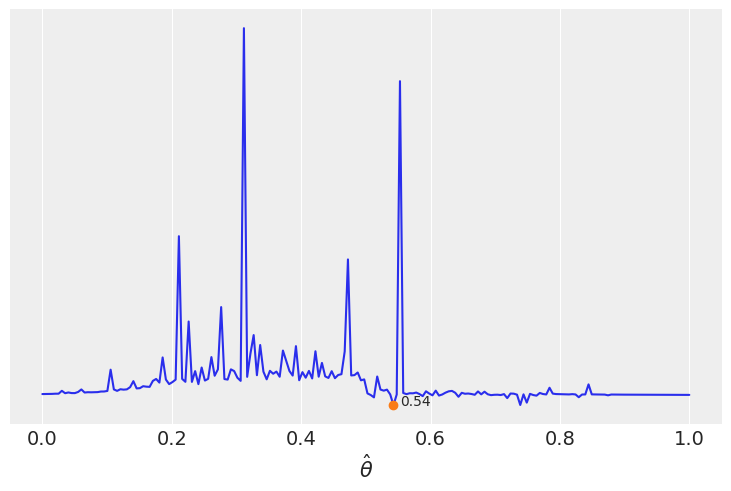

In [13]:

lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos)) # pie * actual_val/(1-actual_val)
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

# Gaussian inferences 
Nuclear Magnetic resonance

([<matplotlib.axis.YTick at 0x7f3e85e92810>],
 <a list of 1 Text major ticklabel objects>)

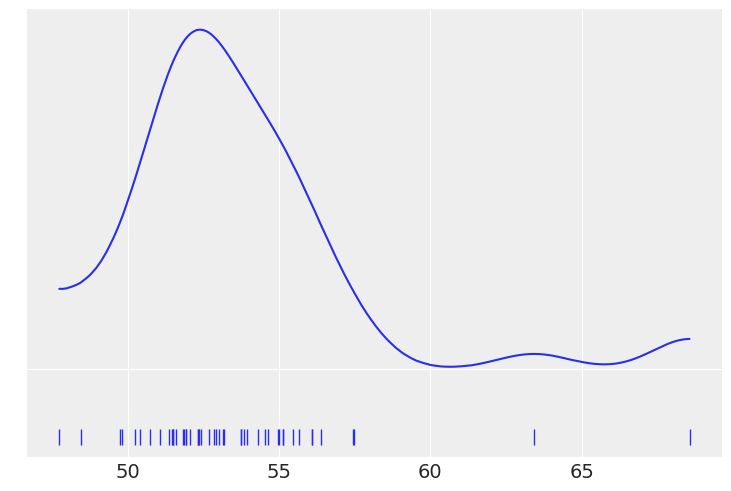

In [16]:
data = np.loadtxt('chemical_shifts.txt') 
az.plot_kde(data, rug=True) 
plt.yticks([0], alpha=0)


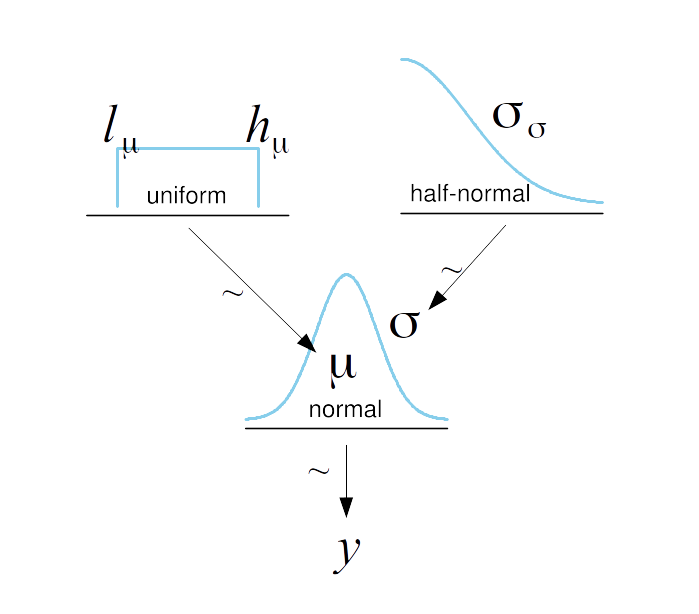

for uniform distribution:
* We choose range larger than the range of the data. 
* Alternatively, we can choose a range based on our previous knowledge



In [17]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e8cddd5d0>,
      dtype=object)

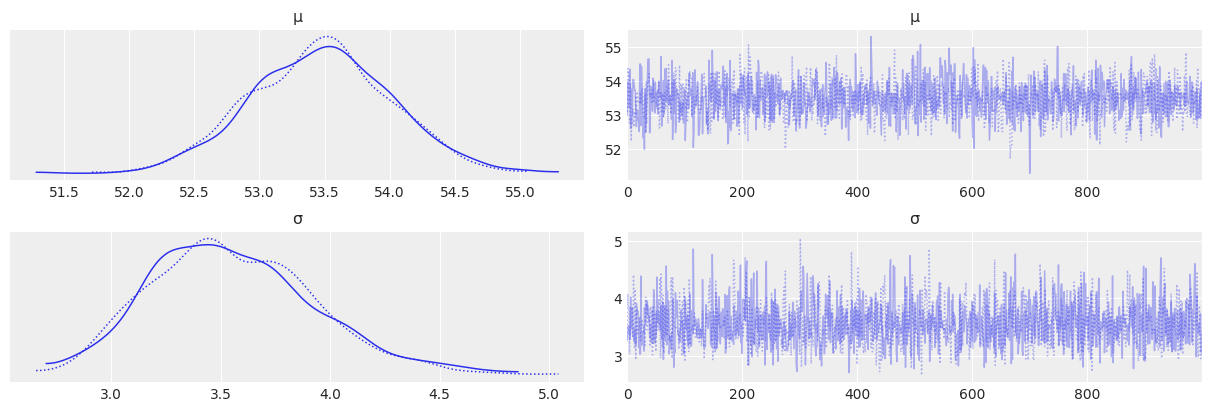

In [18]:
az.plot_trace(trace_g)

For this model, the posterior is bi- dimensional

/usr/local/lib/python3.7/dist-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/utils.py:409: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_cov" failed type inference due to: Untyped global name '_dot': cannot determine Numba type of <class 'arviz.utils.maybe_numba_fn'>

File "../usr/local/lib/python3.7/dist-packages/arviz/utils.py", line 421:
def _cov(data):
    <source elided>
        x -= avg[:, None]
        prod = _dot(x

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e90346e50>,
      dtype=object)

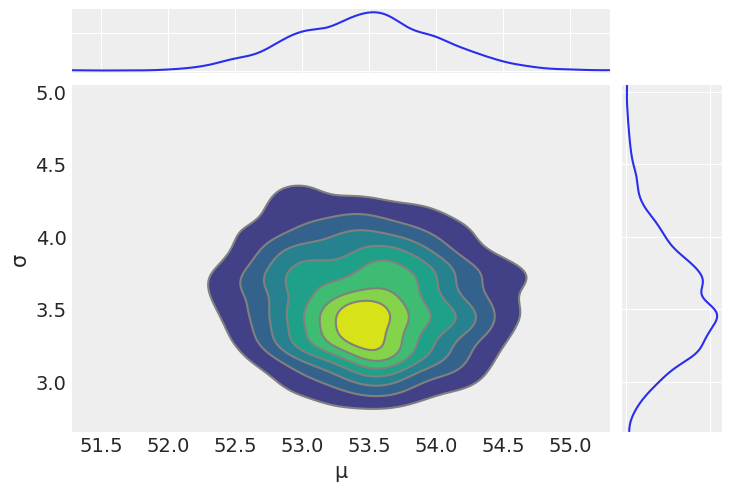

In [19]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [20]:
az.summary(trace_g)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.472,0.532,52.481,54.463,0.013,0.009,1580.0,1019.0,1.0
σ,3.559,0.376,2.892,4.269,0.009,0.006,1882.0,1334.0,1.0


* Now that we have computed the posterior, we can use it to simulate data and check how consistent the simulated is data with respect to the observed data.
* We generically call this type of comparisons **posterior predictive checks**, because we are using the posterior to make predictions, and are using those predictions to check the model.


In [21]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [22]:
len(y_pred_g['y']) #100
len(y_pred_g['y'][0]) #48
#100 samples of size 48

48

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


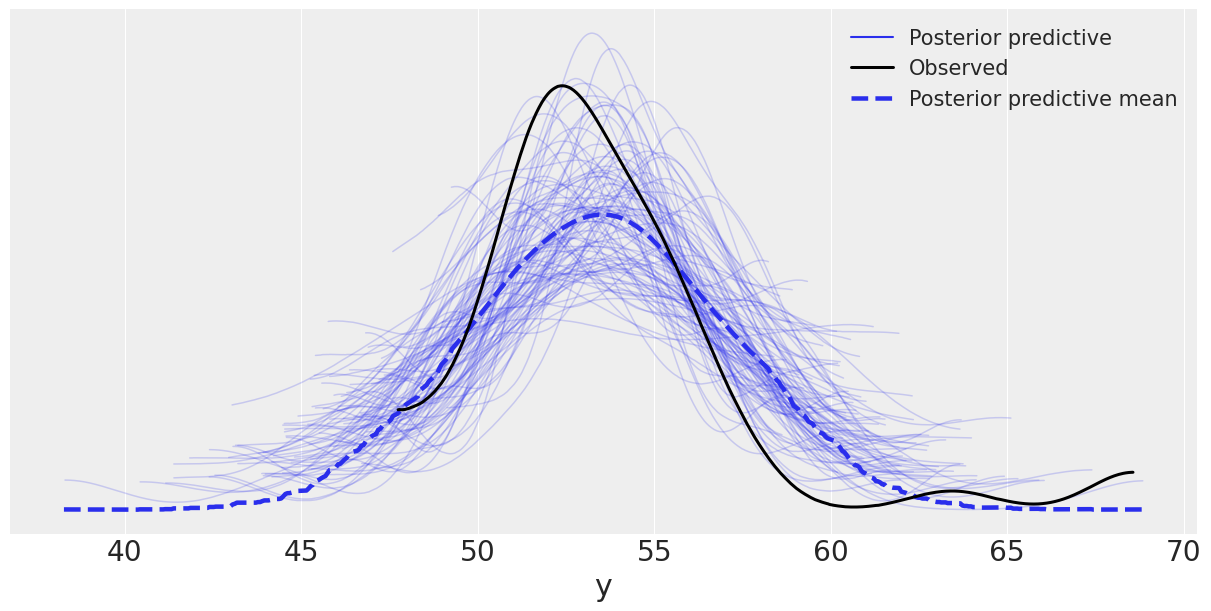

In [23]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
ax.legend(fontsize=15)




*   The mean of the simulated data is slightly displaced to the right
*   The variance seems to be larger for the simulated data than for the actual data
* This is a direct consequence of the two observations that are separated from the bulk of the data




# Student's t-distribution
for dealing with outliers in NMR data

(-5.0, 5.0)

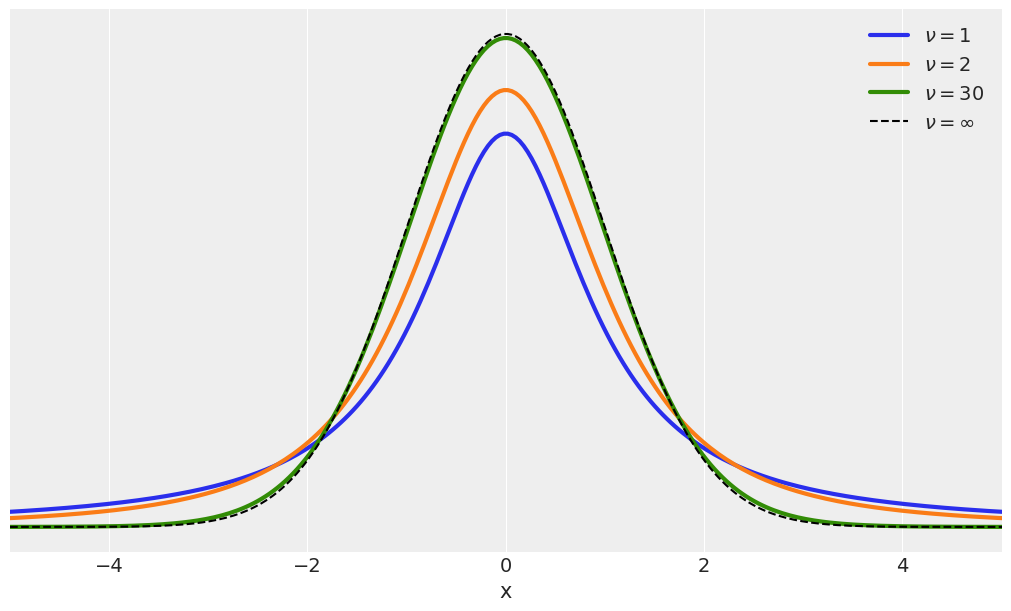

In [24]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

Applying Student's-t distribution to previous problem

student's-t has one more parameter v (degree's of freedom), so we need one more prior, which here is exponential dist with mean 30.

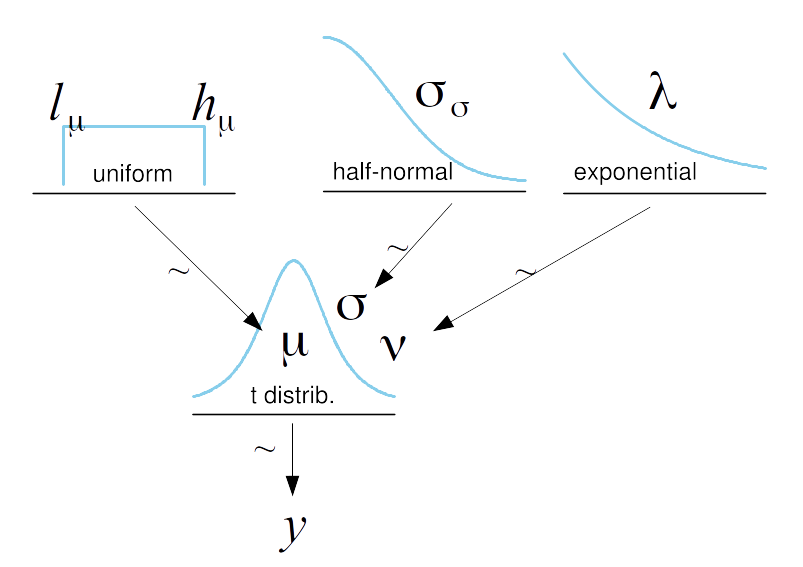

In [25]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30) #exponential in PyMC3 is parameterized with the inverse of the mean
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.623924393911321, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e75ff2d90>,
      dtype=object)

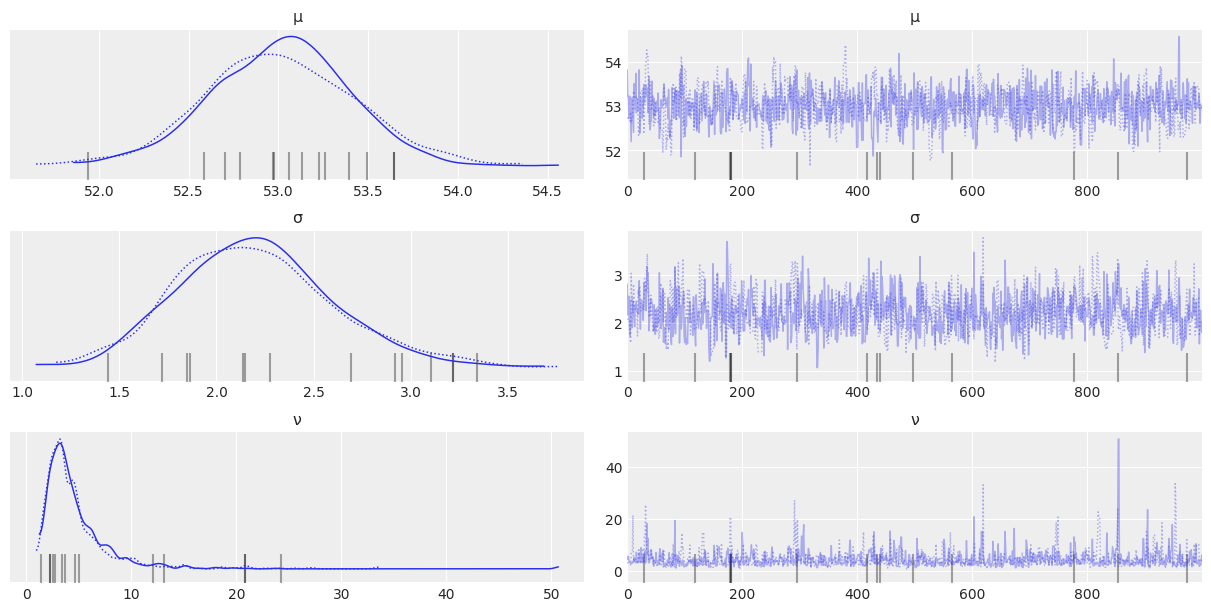

In [26]:
az.plot_trace(trace_t)

In [27]:
az.summary(trace_t)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.007,0.402,52.266,53.785,0.014,0.010,782.0,862.0,1.0
σ,2.200,0.399,1.393,2.892,0.015,0.011,695.0,881.0,1.0
ν,4.668,3.521,1.199,9.891,0.122,0.086,769.0,844.0,1.0


/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(40.0, 70.0)

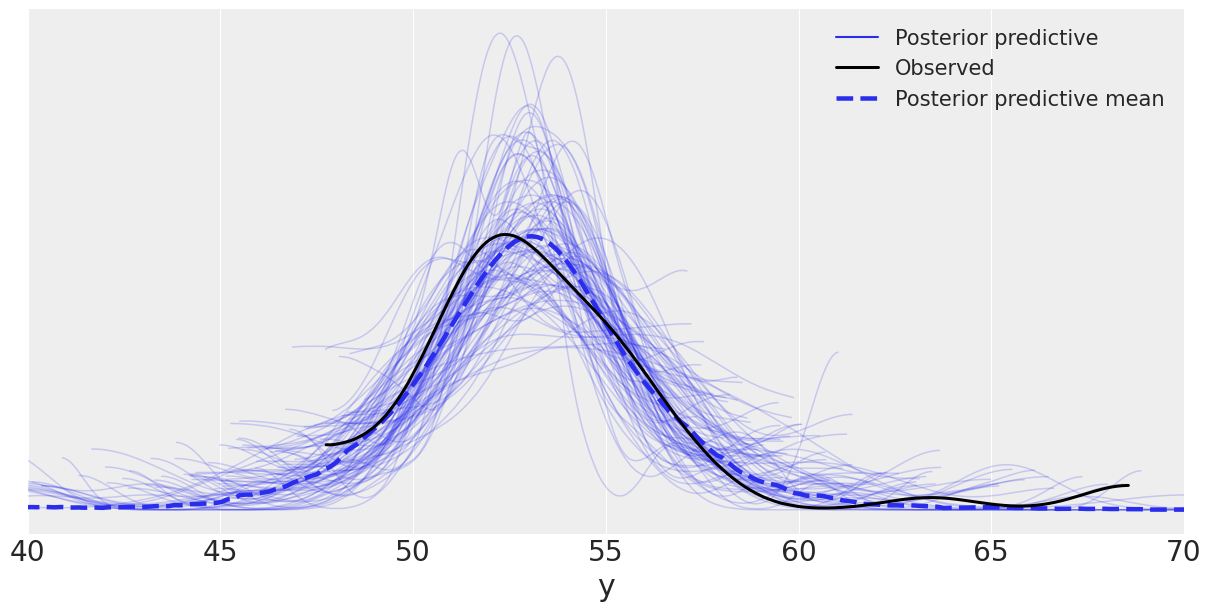

In [28]:
y_ppc_t = pm.sample_posterior_predictive(trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=True)
ax.legend(fontsize=15)
plt.xlim(40, 70)

# Tips Dataset

In [29]:
tips = pd.read_csv('tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


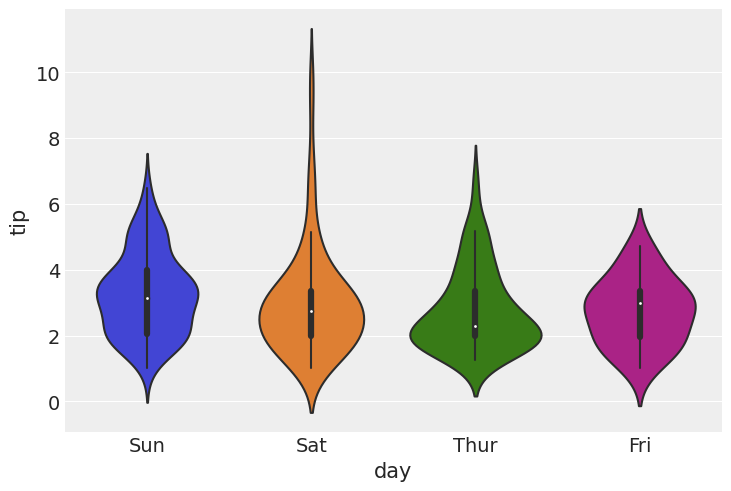

In [30]:
sns.violinplot(x='day', y='tip', data=tips)

In [31]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [33]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) #vectors instead of scalars
    σ = pm.HalfNormal('σ', sd=10, shape=groups)   #vectors instead of scalars

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e75566d50>,
      dtype=object)

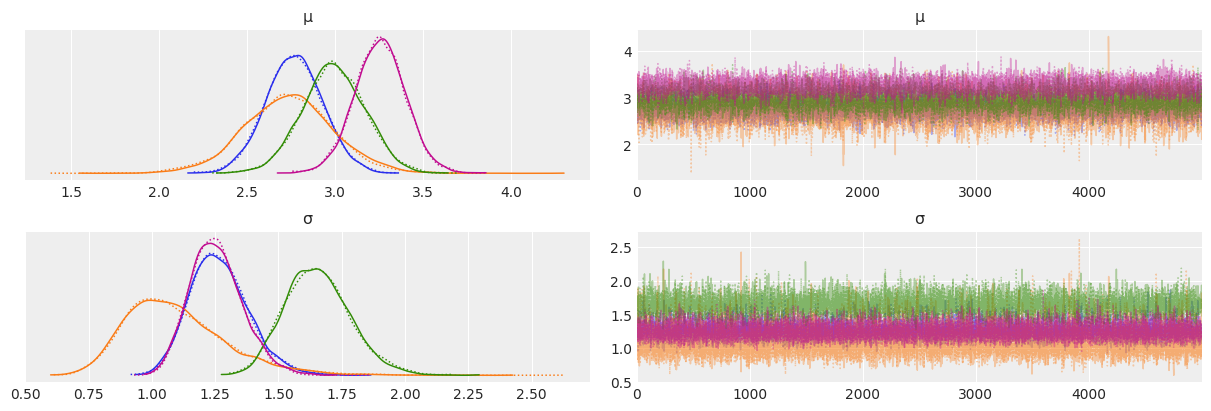

In [34]:
az.plot_trace(trace_cg)

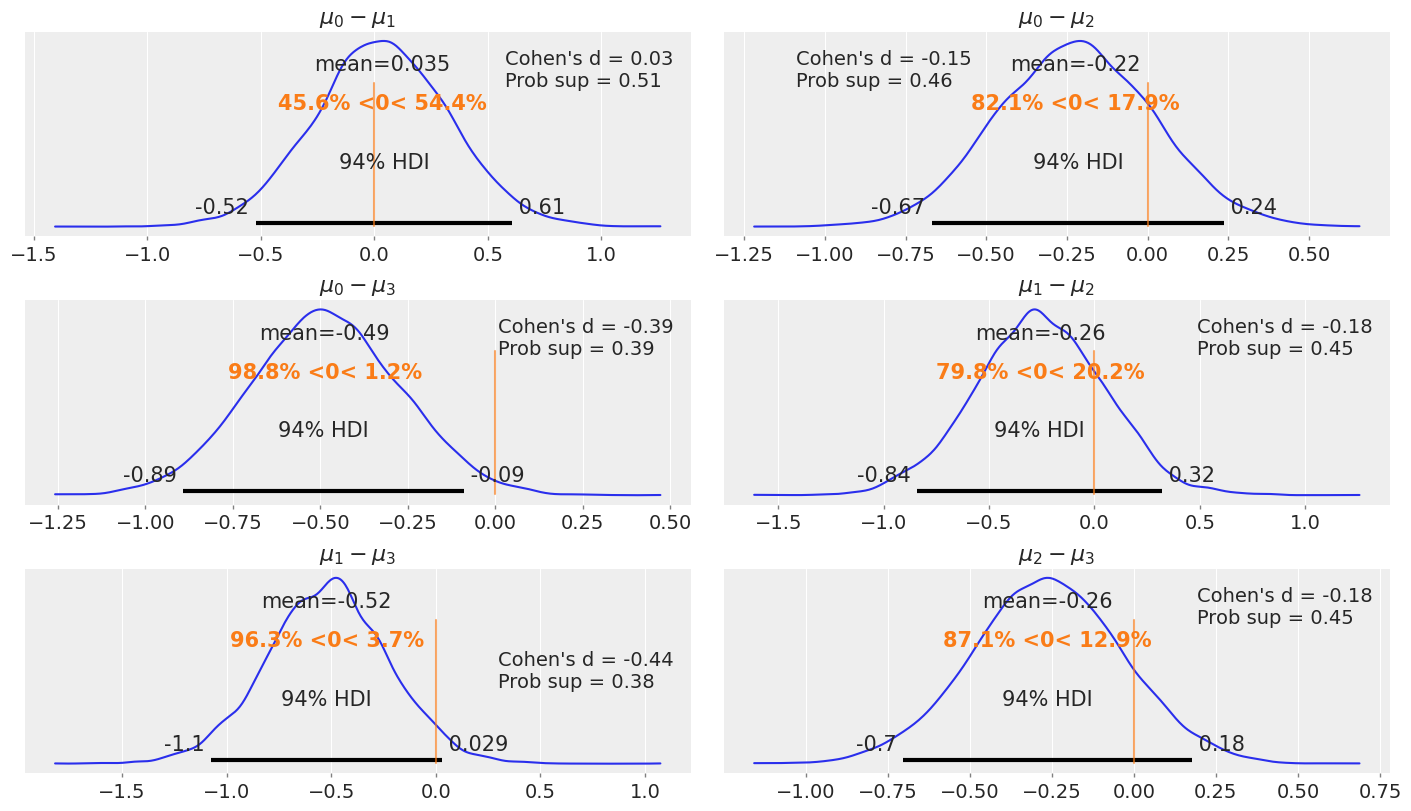

In [35]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()